# 对EMNIST字母数据集的26类别分类任务的神经网络设计思路
卷积层提取空间特征,全连接层进行最后的分类,最大池化用来降维,防止过拟合,因此有
1.用卷积层来提取图像的空间特征,并通过池化层降低分辨率
2.展平层将4维的特征图变为2维
3.全连接层进一步学习特征之间的关系,进行final分类
4.激活函数relu用于引入非线性

In [3]:


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
# 下载训练集测试集
##train_dataset = datasets.EMNIST(root='./data', split='letters', train=True, download=True)

##test_dataset = datasets.EMNIST(root='./data', split='letters', train=False, download=True)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5) #卷积层,输入通道数1,输出通道数10,核大小5x5,输出10个特征图
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50) # fc1:第一个全连接层,输入320个特征,输出50个特征
        self.fc2 = nn.Linear(50, 26)  # 输出26个类别

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.max_pool2d(x, 2) # max_pool2d:最大池化层,核大小2x2,步长2,它会将conv1的输出缩小2倍
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.max_pool2d(x, 2)
        x = x.view(-1, 320) # view:将4维的特征图展平为2维,变为320个特征
        x = nn.functional.relu(self.fc1(x)) # relu:两个卷积层和第一个全连接层的激活函数,用于引入非线性
        x = self.fc2(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:

# 超参数
batch_size = 1024
learning_rate = 0.001
num_epochs = 10

# 准备数据集
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.EMNIST(
    root='./data', split='letters', train=True, download=True, transform=transform
)

test_dataset = datasets.EMNIST(
    root='./data', split='letters', train=False, download=True, transform=transform
)

train_dataset.targets = train_dataset.targets - 1
test_dataset.targets = test_dataset.targets - 1

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = Net().to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 定义存储损失的列表以备画图
train_losses = []
val_losses = []
# 训练模型
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        if (i+1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    # 在每个训练周期结束后计算验证损失
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(test_loader)
        val_accuracy = val_correct / val_total
        val_losses.append(avg_val_loss)
        print('Validation Loss: {:.4f}, Validation Accuracy: {:.2f}%'.format(avg_val_loss, val_accuracy * 100))

# 保存模型
torch.save(model.state_dict(), 'model.ckpt')


  0%|          | 0/561753746 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# 绘制损失函数图表
plt.plot(train_losses, label='Steps-Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(val_losses, label='Epochs-Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 提高效果-归一化层
对卷积层的输出进行归一化

1. 即使输入分布变化也可以稳定网络
2. 允许使用更高的学习率,还能加速网络训练
3. 减轻梯度消失问题,使信息更好地传递到较深的网络层

后半段Steps-Loss方差更小, 但是没有很大差距

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 1024
learning_rate = 0.001
num_epochs = 15

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.EMNIST(
    root='./data', split='letters', train=True, download=True, transform=transform
)

test_dataset = datasets.EMNIST(
    root='./data', split='letters', train=False, download=True, transform=transform
)

train_dataset.targets = train_dataset.targets - 1
test_dataset.targets = test_dataset.targets - 1

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(10)  # 批归一化层
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(20)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 26)

    def forward(self, x):
        x = nn.functional.relu(self.bn1(self.conv1(x)))  # 在激活函数之前应用批归一化
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.bn2(self.conv2(x)))
        x = nn.functional.max_pool2d(x, 2)
        x = x.view(-1, 320)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = Net().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
val_losses = []  # 存储每数据批次的验证损失

# 训练模型
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))

    # 在每个训练周期结束后计算每代次的验证损失
    model.eval()
    val_loss = 0.0
    val_total = 0
    val_correct = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)


            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(test_loader)
        val_losses.append(avg_val_loss)


    model.train()  # 切换回训练模式
    val_accuracy = val_correct / val_total

    print('Validation Loss: {:.4f}, Validation Accuracy: {:.2f}%'.format(avg_val_loss, val_accuracy * 100))

torch.save(model.state_dict(), 'model.ckpt')

plt.plot(train_losses, label='Steps-Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(val_losses, label='Epochs-Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# 学习率范围测试

Epoch [1/4], Step [100/122], Loss: 0.4097
Epoch [2/4], Step [100/122], Loss: 0.2819
Epoch [3/4], Step [100/122], Loss: 0.3121
Epoch [4/4], Step [100/122], Loss: 3.2760
Minimum loss learning rate: 0.1072351753455342


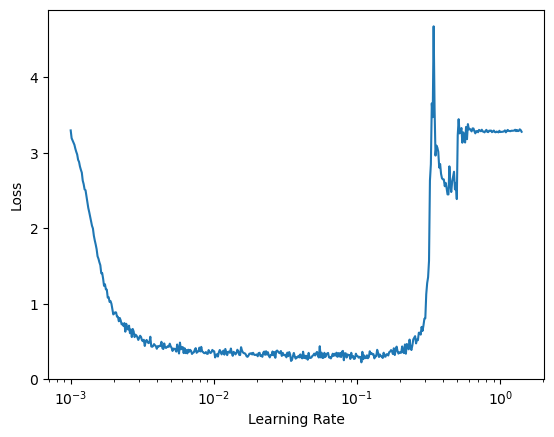

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 1024
learning_rate = 1e-3
num_epochs = 4
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_dataset = datasets.EMNIST(
    root='./data', split='letters', train=True, download=True, transform=transform
)
test_dataset = datasets.EMNIST(
    root='./data', split='letters', train=False, download=True, transform=transform
)
train_dataset.targets = train_dataset.targets - 1
test_dataset.targets = test_dataset.targets - 1
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(10)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(20)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 26)

    def forward(self, x):
        x = nn.functional.relu(self.bn1(self.conv1(x)))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.bn2(self.conv2(x)))
        x = nn.functional.max_pool2d(x, 2)
        x = x.view(-1, 320)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x
model = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
val_losses = []
total_step = len(train_loader)
lr_values = []  # 记录每个批次的学习率

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        lr_values.append(optimizer.param_groups[0]['lr'])  # 记录当前批次的学习率

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))

        # 动态调整学习率
        optimizer.param_groups[0]['lr'] *= 1.015

# 找到最小损失对应的学习率
min_loss_index = np.argmin(train_losses)
min_loss_lr = lr_values[min_loss_index]

print("Minimum loss learning rate:", min_loss_lr)

# 绘制学习率与损失的曲线图
plt.plot(lr_values, train_losses)
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.xscale('log')
plt.show()

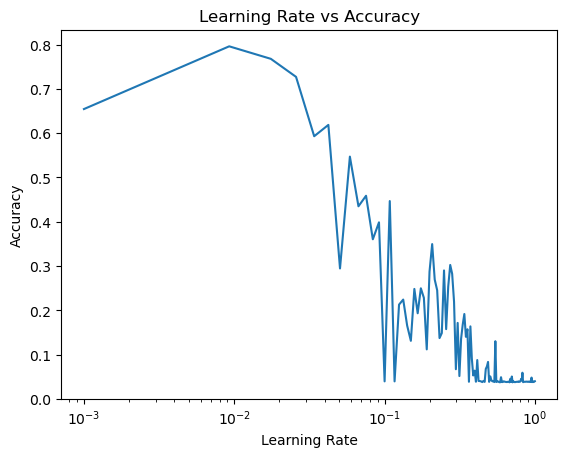

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 1024
num_epochs = 1

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.EMNIST(
    root='./data', split='letters', train=True, download=True, transform=transform
)

test_dataset = datasets.EMNIST(
    root='./data', split='letters', train=False, download=True, transform=transform
)

train_dataset.targets = train_dataset.targets - 1
test_dataset.targets = test_dataset.targets - 1

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(10)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(20)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 26)

    def forward(self, x):
        x = nn.functional.relu(self.bn1(self.conv1(x)))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.bn2(self.conv2(x)))
        x = nn.functional.max_pool2d(x, 2)
        x = x.view(-1, 320)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 学习率范围
min_lr = 0.001
max_lr = 1.0

# 创建学习率列表
num_steps = len(train_loader)
lrs = np.linspace(min_lr, max_lr, num_steps)

accuracies = []  # 记录每批次的测试准确率

for lr in lrs:
    model = Net().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    model.train()

    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = correct / total
    accuracies.append(accuracy)
    # 释放模型内存
    del model
    torch.cuda.empty_cache()
# 绘制学习率与测试准确率的曲线图
plt.plot(lrs, accuracies)
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.xscale('log')
plt.title('Learning Rate vs Accuracy')
plt.show()


In [3]:
maxAccuracy_index = np.argmax(accuracies)
max_accuracy_lr = lrs[maxAccuracy_index]
print(max_accuracy_lr)

0.009256198347107437


Epoch [1/100], Step [100/122], Loss: 0.3919
Validation Loss: 0.3143, Validation Accuracy: 90.05%
Epoch [2/100], Step [100/122], Loss: 0.2756
Validation Loss: 0.2734, Validation Accuracy: 91.08%
Epoch [3/100], Step [100/122], Loss: 0.2094
Validation Loss: 0.2448, Validation Accuracy: 91.98%
Epoch [4/100], Step [100/122], Loss: 0.2435
Validation Loss: 0.2226, Validation Accuracy: 92.44%
Epoch [5/100], Step [100/122], Loss: 0.2291
Validation Loss: 0.2290, Validation Accuracy: 92.47%
Epoch [6/100], Step [100/122], Loss: 0.2159
Validation Loss: 0.2227, Validation Accuracy: 92.33%
Epoch [7/100], Step [100/122], Loss: 0.1614
Validation Loss: 0.2115, Validation Accuracy: 93.11%
Epoch [8/100], Step [100/122], Loss: 0.1550
Validation Loss: 0.2250, Validation Accuracy: 92.75%
Epoch [9/100], Step [100/122], Loss: 0.2134
Validation Loss: 0.2024, Validation Accuracy: 93.27%
Epoch [10/100], Step [100/122], Loss: 0.1901
Validation Loss: 0.1976, Validation Accuracy: 93.52%
Epoch [11/100], Step [100/122

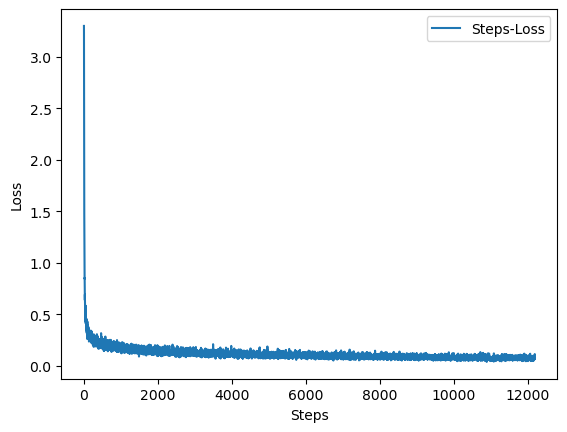

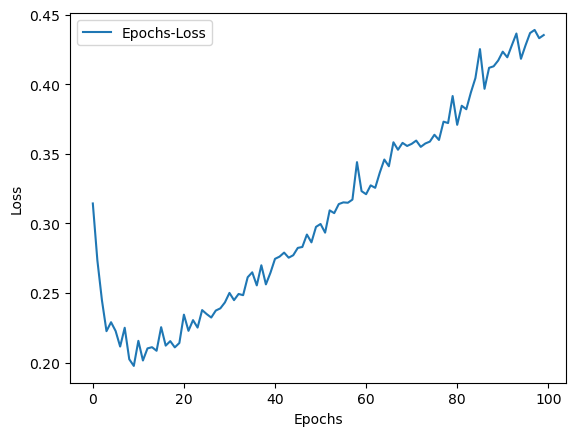

In [4]:
model = Net().to(device)
num_epochs = 100
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=max_accuracy_lr)

train_losses = []
val_losses = []

total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))

    model.eval()
    val_loss = 0.0
    val_total = 0
    val_correct = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)


            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(test_loader)
        val_losses.append(avg_val_loss)


    model.train()
    val_accuracy = val_correct / val_total

    print('Validation Loss: {:.4f}, Validation Accuracy: {:.2f}%'.format(avg_val_loss, val_accuracy * 100))

torch.save(model.state_dict(), 'model.ckpt')

plt.plot(train_losses, label='Steps-Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(val_losses, label='Epochs-Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# 调整学习率没有用, 增加网络的复杂性

Epoch [1/10], Step [100/122], Loss: 0.2036
Validation Loss: 0.2306, Accuracy: 92.47%
Epoch [2/10], Step [100/122], Loss: 0.1760
Validation Loss: 0.1954, Accuracy: 93.11%
Epoch [3/10], Step [100/122], Loss: 0.2091
Validation Loss: 0.2057, Accuracy: 93.13%
Epoch [4/10], Step [100/122], Loss: 0.1156
Validation Loss: 0.1758, Accuracy: 93.76%
Epoch [5/10], Step [100/122], Loss: 0.1274
Validation Loss: 0.2202, Accuracy: 92.86%
Epoch [6/10], Step [100/122], Loss: 0.0929
Validation Loss: 0.1805, Accuracy: 93.73%
Epoch [7/10], Step [100/122], Loss: 0.1209
Validation Loss: 0.2074, Accuracy: 93.16%
Epoch [8/10], Step [100/122], Loss: 0.0938
Validation Loss: 0.1831, Accuracy: 93.90%
Epoch [9/10], Step [100/122], Loss: 0.0735
Validation Loss: 0.1945, Accuracy: 93.71%
Epoch [10/10], Step [100/122], Loss: 0.0757
Validation Loss: 0.1852, Accuracy: 94.01%


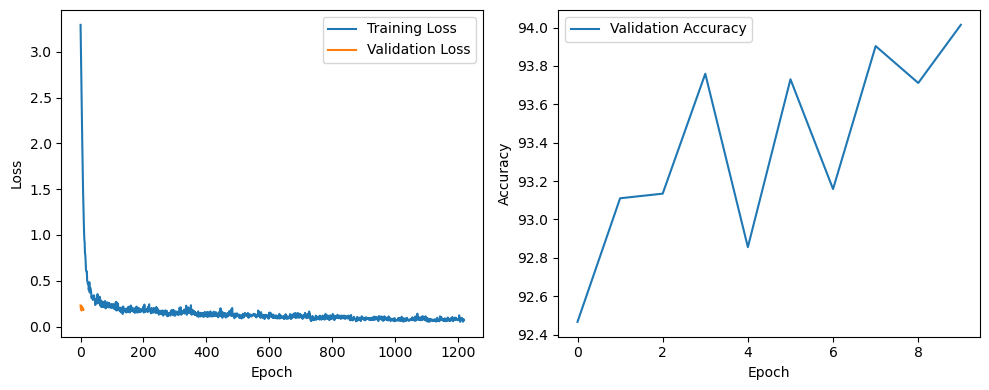

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 1024
learning_rate = 0.001
num_epochs = 10

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.EMNIST(
    root='./data', split='letters', train=True, download=True, transform=transform
)
test_dataset = datasets.EMNIST(
    root='./data', split='letters', train=False, download=True, transform=transform
)

train_dataset.targets = train_dataset.targets - 1
test_dataset.targets = test_dataset.targets - 1

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class ComplexNet(nn.Module):
    def __init__(self):
        super(ComplexNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.fc1 = nn.Linear(256, 512)
        self.fc2 = nn.Linear(512, 26)

    def forward(self, x):
        x = nn.functional.relu(self.bn1(self.conv1(x)))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.bn2(self.conv2(x)))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.bn3(self.conv3(x)))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.bn4(self.conv4(x)))
        x = nn.functional.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = ComplexNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
val_losses = []
val_accuracies = []

total_step = len(train_loader)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))

    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)


            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= len(test_loader)
    val_accuracy = 100.0 * val_correct / val_total

    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print('Validation Loss: {:.4f}, Accuracy: {:.2f}%'.format(val_loss, val_accuracy))

    model.train()

# 绘制学习曲线
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
torch.save(model.state_dict(), 'ComplexNet.ckpt')

# 个人上传图像测试泛化能力

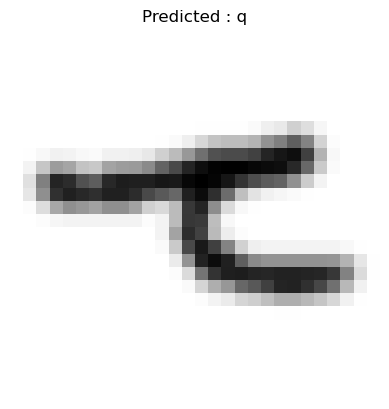

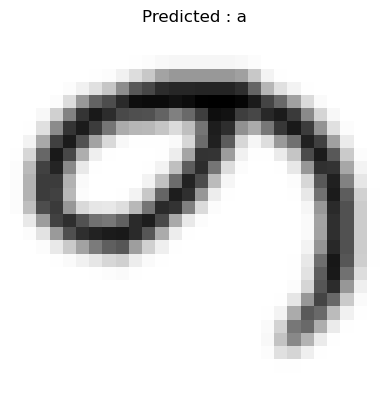

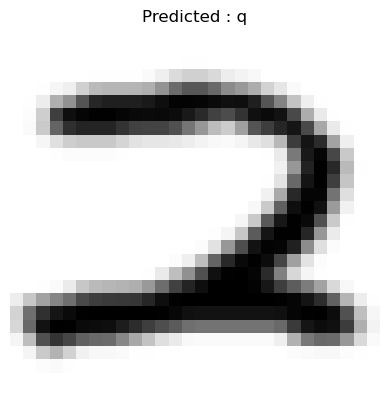

In [23]:

import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# 加载模型
model = ComplexNet().to(device)
model.load_state_dict(torch.load('ComplexNet.ckpt'))
model.eval()

# 图像预处理
transform = transforms.Compose([
    transforms.Grayscale(),  # 转为灰度图像
    transforms.Resize((28, 28)),  # 调整大小为28x28像素
    transforms.ToTensor(),  # 转为Tensor
    transforms.Normalize((0.1307,), (0.3081,))  # 标准化
])

# 加载并预处理测试图片
image_paths = ['image4.png', 'image5.png', 'image6.png']  # 替换为你的图像路径
for image_path in image_paths:
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0).to(device)  # 添加批次维度并移动到设备

    # 模型预测
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)

    # 可视化预测结果
    plt.imshow(image.squeeze().cpu(), cmap='gray')
    plt.title(f"Predicted : {chr(predicted.item()+97)}")
    plt.axis('off')
    plt.show()


# 结论: 可能对自定义输入数据的处理非常重要, 并且泛化能力的提高是难点, 为此使用L2正则化和Dropout来防止过拟合，使用ReLU激活函数和RMSprop优化器

Epoch [1/50], Step [100/122], Loss: 0.5583
Validation Loss: 0.4076, Accuracy: 86.01%
Epoch [2/50], Step [100/122], Loss: 0.3291
Validation Loss: 0.2484, Accuracy: 91.68%
Epoch [3/50], Step [100/122], Loss: 0.2853
Validation Loss: 0.1956, Accuracy: 93.15%
Epoch [4/50], Step [100/122], Loss: 0.2344
Validation Loss: 0.1964, Accuracy: 93.08%
Epoch [5/50], Step [100/122], Loss: 0.1997
Validation Loss: 0.1789, Accuracy: 93.74%
Epoch [6/50], Step [100/122], Loss: 0.1899
Validation Loss: 0.1736, Accuracy: 93.96%
Epoch [7/50], Step [100/122], Loss: 0.1935
Validation Loss: 0.1713, Accuracy: 94.10%
Epoch [8/50], Step [100/122], Loss: 0.1880
Validation Loss: 0.1632, Accuracy: 94.25%
Epoch [9/50], Step [100/122], Loss: 0.1446
Validation Loss: 0.1605, Accuracy: 94.50%
Epoch [10/50], Step [100/122], Loss: 0.1996
Validation Loss: 0.1609, Accuracy: 94.46%
Epoch [11/50], Step [100/122], Loss: 0.1613
Validation Loss: 0.1583, Accuracy: 94.49%
Epoch [12/50], Step [100/122], Loss: 0.1602
Validation Loss: 0.

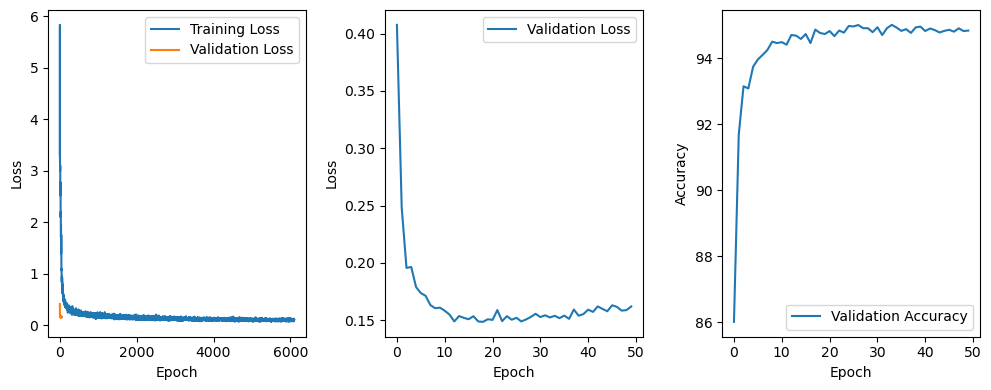

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 1024
learning_rate = 0.001
num_epochs = 50

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.EMNIST(
    root='./data', split='letters', train=True, download=True, transform=transform
)
test_dataset = datasets.EMNIST(
    root='./data', split='letters', train=False, download=True, transform=transform
)

train_dataset.targets = train_dataset.targets - 1
test_dataset.targets = test_dataset.targets - 1

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class ComplexNet(nn.Module):
    def __init__(self):
        super(ComplexNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.dropout1 = nn.Dropout2d(0.25)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.dropout2 = nn.Dropout2d(0.25)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.dropout3 = nn.Dropout2d(0.25)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.dropout4 = nn.Dropout2d(0.25)
        self.fc1 = nn.Linear(256, 512)
        self.fc2 = nn.Linear(512, 26)

    def forward(self, x):
        x = nn.functional.relu(self.bn1(self.conv1(x)))
        x = nn.functional.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = nn.functional.relu(self.bn2(self.conv2(x)))
        x = nn.functional.max_pool2d(x, 2)
        x = self.dropout2(x)
        x = nn.functional.relu(self.bn3(self.conv3(x)))
        x = nn.functional.max_pool2d(x, 2)
        x = self.dropout3(x)
        x = nn.functional.relu(self.bn4(self.conv4(x)))
        x = nn.functional.max_pool2d(x, 2)
        x = self.dropout4(x)
        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = ComplexNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-5)

train_losses = []
val_losses = []
val_accuracies = []

total_step = len(train_loader)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))

    # 在每个epoch结束后，计算模型在验证集上的损失和准确率
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= len(test_loader)
    val_accuracy = 100.0 * val_correct / val_total

    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print('Validation Loss: {:.4f}, Accuracy: {:.2f}%'.format(val_loss, val_accuracy))

    model.train()

# 绘制学习曲线
plt.figure(figsize=(10, 4))
plt.subplot(1, 3,1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 3, 2)
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
torch.save(model.state_dict(), 'ComplexNet.ckpt')


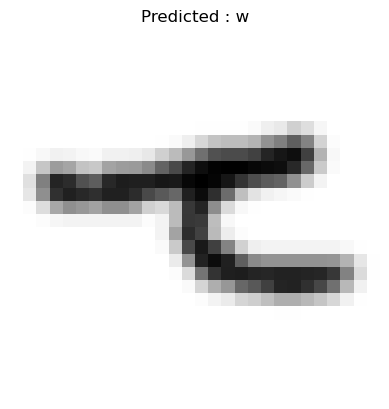

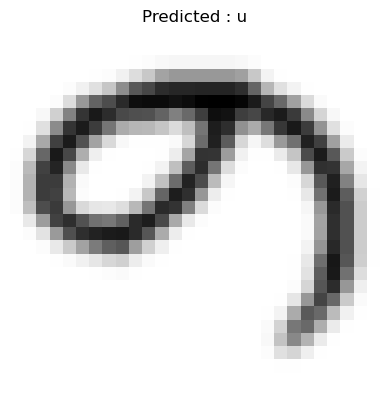

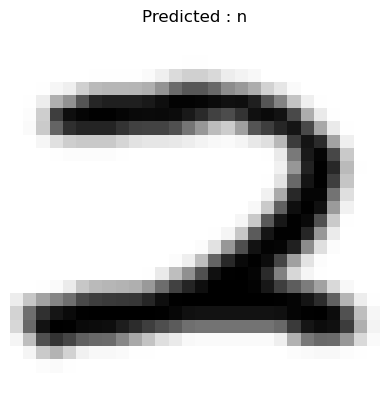

In [34]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# 加载模型
model = ComplexNet().to(device)
model.load_state_dict(torch.load('ComplexNet2.ckpt'))
model.eval()

# 图像预处理
transform = transforms.Compose([
    transforms.Grayscale(),  # 转为灰度图像
    transforms.Resize((28, 28)),  # 调整大小为28x28像素
    transforms.ToTensor(),  # 转为Tensor
    transforms.Normalize((0.1307,), (0.3081,))  # 标准化
])

# 加载并预处理测试图片
image_paths = ['image4.png', 'image5.png', 'image6.png']  # 替换为你的图像路径
for image_path in image_paths:
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0).to(device)  # 添加批次维度并移动到设备

    # 模型预测
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)

    # 可视化预测结果
    plt.imshow(image.squeeze().cpu(), cmap='gray')
    plt.title(f"Predicted : {chr(predicted.item()+97)}")
    plt.axis('off')
    plt.show()

# 优化的网络明显可以保持准确率稳定, 但是无法继续提高, 泛化能力有了明显进展, 可以辨认任给图像的相似特征, 但也无法判别未经严格处理的图像, 对于测试集的准确率则高达95%, 但也止步于95%, 要提高泛化能力训练集的量也应该足够大

# EMNIST字母测试集测试

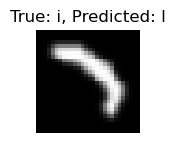

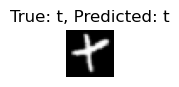

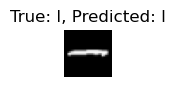

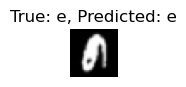

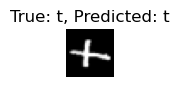

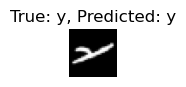

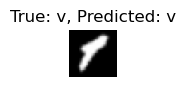

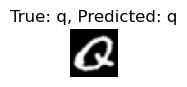

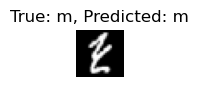

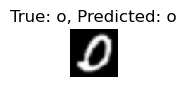

In [42]:
import numpy as np
import random
model.eval()

with torch.no_grad():
    test_images = []
    true_labels = []
    predicted_labels = []
    indices = random.sample(range(len(test_dataset)), 10)  # 随机选择10个样本的索引
    for i in indices:
        image, label = test_dataset[i]
        image = image.unsqueeze(0).to(device)
        label = torch.tensor(label).unsqueeze(0).to(device)

        output = model(image)
        _, predicted = torch.max(output.data, 1)

        test_images.append(image.cpu().numpy())
        true_labels.append(label.cpu().numpy())
        predicted_labels.append(predicted.cpu().numpy())


test_images = np.concatenate(test_images, axis=0)
true_labels = np.concatenate(true_labels, axis=0)
predicted_labels = np.concatenate(predicted_labels, axis=0)

# 可视化10个测试样本及其预测结果
num_samples = len(indices)

plt.figure(figsize=(12, 6))
for i in range(num_samples):
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(test_images[i].squeeze(), cmap='gray')
    plt.axis('off')
    plt.title(f'True: {chr(true_labels[i]+97)}, Predicted: {chr(predicted_labels[i]+97)}')
    plt.tight_layout()
    plt.show()




# 5%无法判定的部分确实是人眼也不好分辨的部分